# Analysis of Yelp Business Intelligence Data

We will analyze a subset of Yelp's business, reviews and user data. \
This dataset comes to us from Kaggle although we have taken steps to pull this data into a publis s3 bucket:

`s3://yelp-dataset-cis9760/yelp_academic_dataset_business.json` \
`s3://yelp-dataset-cis9760/yelp_academic_dataset_checkin.json` \
`s3://yelp-dataset-cis9760/yelp_academic_dataset_review.json` \
`s3://yelp-dataset-cis9760/yelp_academic_dataset_tip.json` \
`s3://yelp-dataset-cis9760/yelp_academic_dataset_user.json`

# Part I - Installation and Initial Setup

Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install `pandas` and `matplotlib`

In [1]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("scipy==1.7.1")
sc.install_pypi_package("seaborn==0.11.1")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
4,application_1651330621840_0005,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/4a/6a/94b219b8ea0f2d580169e85ed1edc0163743f55aaeca8a44c2e8fc1e344e/pandas-1.0.3-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/36/7a/87837f39d0296e723bb9b62bbb257d0355c7f6128853c78955f57342a56d/python_dateutil-2.8.2-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/b2/c2/71fcf957710f3ba1f09088b35776a799ba7dd95f7c2b195ec800933b276b/matplotlib-3.2.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d9/41/d9cfb4410589805cd787f8a82cddd13142d9bf7449d12adf2d05a4a7d633/pyparsing-3.0.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5c/f9/695d6bedebd747e5eb0fe8fad57b72fdf25411273a39791cde838d5a8f51/cycler-0.11.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/51/50/9a9a94afa26c50fc5d9127272737806990aa698c7a1c220b8e5075e70304/kiwisolver-1.4.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_

In [2]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version  
-------------------------- ---------
beautifulsoup4             4.9.1    
boto                       2.49.0   
click                      7.1.2    
cycler                     0.11.0   
jmespath                   0.10.0   
joblib                     0.16.0   
kiwisolver                 1.4.2    
lxml                       4.5.2    
matplotlib                 3.2.1    
mysqlclient                1.4.2    
nltk                       3.5      
nose                       1.3.4    
numpy                      1.16.5   
pandas                     1.0.3    
pip                        9.0.1    
py-dateutil                2.2      
pyparsing                  3.0.8    
python-dateutil            2.8.2    
python37-sagemaker-pyspark 1.4.0    
pytz                       2020.1   
PyYAML                     5.3.1    
regex                      2020.7.14
scipy                      1.7.1    
seaborn                    0.11.1   
setuptools                 28.8.0   
s

## Importing

Now, import the installed packages from the previous block below.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk import FreqDist

from scipy import stats
from scipy.stats import skew
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
from pyspark.sql.functions import mean, stddev, col, abs, split, explode, avg
from pyspark.sql import functions as F

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data

We are finally ready to load data. Using spark load the data from S3 into a dataframe object that we can manipulate further down in our analysis.

In [4]:
business = spark.read.json('s3://yelp-dataset-cis9760/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
business.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|[,,,,,,,,,,, True...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|Santa Barbara|                null|      0|34.4266787|-119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|[,,,,,,,,, True,,...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|       Affton|[8:0-18:30, 0:0-0...|      1| 38.551126|  -90.335695|    

# Overview of Data

Display the number of rows and columns in our dataset.

In [6]:
print(f'Number of columns in Business table: {len(business.dtypes)}')
print(f'Number of rows in Business table: {business.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of columns in Business table: 14
Number of rows in Business table: 150,346

In [7]:
business.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

* `business_id`
* `name`
* `city`
* `state`
* `categories`

In [8]:
business.select("business_id", "name", "city", "state", "categories").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-------------+-----+--------------------+
|         business_id|                name|         city|state|          categories|
+--------------------+--------------------+-------------+-----+--------------------+
|Pns2l4eNsfO8kk83d...|Abby Rappoport, L...|Santa Barbara|   CA|Doctors, Traditio...|
|mpf3x-BjTdTEA3yCZ...|       The UPS Store|       Affton|   MO|Shipping Centers,...|
|tUFrWirKiKi_TAnsV...|              Target|       Tucson|   AZ|Department Stores...|
|MTSW4McQd7CbVtyjq...|  St Honore Pastries| Philadelphia|   PA|Restaurants, Food...|
|mWMc6_wTdE0EUBKIG...|Perkiomen Valley ...|   Green Lane|   PA|Brewpubs, Breweri...|
+--------------------+--------------------+-------------+-----+--------------------+
only showing top 5 rows

# Part II - Analyzing Categories

Let's now answer this question: **how many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

* How many businesses are categorized as `Active Life`, for instance
* What are the top 20 most popular categories available?

## Association Table

We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:


| business_id | categories |
|-------------|------------|
| abcd123     | a,b,c      |

We would like to derive something like:

| business_id | category |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from your original yelp dataframe.

In [9]:
# Install the necessary libraries here
from pyspark.sql.functions import col, split

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
business_categories=business.select("business_id", explode(split("categories" , ", ")).alias("category"))
business_categories.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|         business_id|            category|
+--------------------+--------------------+
|Pns2l4eNsfO8kk83d...|             Doctors|
|Pns2l4eNsfO8kk83d...|Traditional Chine...|
|Pns2l4eNsfO8kk83d...|Naturopathic/Holi...|
|Pns2l4eNsfO8kk83d...|         Acupuncture|
|Pns2l4eNsfO8kk83d...|    Health & Medical|
+--------------------+--------------------+
only showing top 5 rows

# Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

Below, implement the code necessary to calculate this figure.

In [11]:
unique_cat = business_categories.select("category").distinct()
unique_cat.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1311

## Top Categories By Business

Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category

So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [12]:
top_cat = business_categories.groupby("category").count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Bar Chart of Top Categories

With this data available, let us now build a barchart of the top 20 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

If you want, you can also use seaborn library

In [13]:
top_cat_sorted = top_cat.sort(col("count").desc())
top_cat_sorted.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            category|count|
+--------------------+-----+
|         Restaurants|52268|
|                Food|27781|
|            Shopping|24395|
|       Home Services|14356|
|       Beauty & Spas|14292|
|           Nightlife|12281|
|    Health & Medical|11890|
|      Local Services|11198|
|                Bars|11065|
|          Automotive|10773|
|Event Planning & ...| 9895|
|          Sandwiches| 8366|
|American (Traditi...| 8139|
|         Active Life| 7687|
|               Pizza| 7093|
|        Coffee & Tea| 6703|
|           Fast Food| 6472|
|  Breakfast & Brunch| 6239|
|      American (New)| 6097|
|     Hotels & Travel| 5857|
+--------------------+-----+
only showing top 20 rows

In [14]:
tcs = top_cat_sorted.limit(20).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

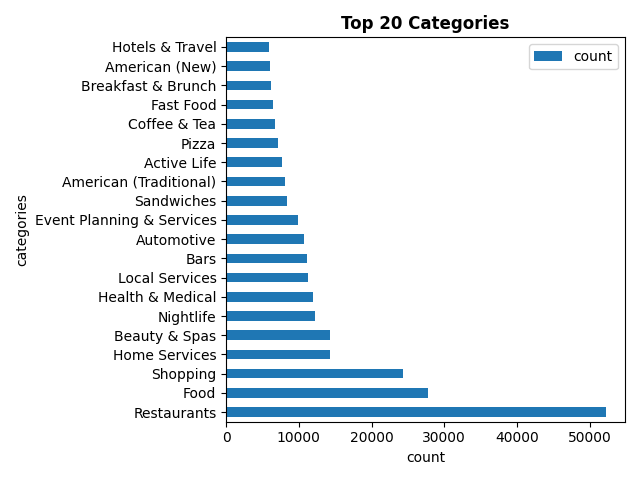

In [15]:
fig, ax = plt.subplots(figsize=(12,8)) 
tcs.plot(kind="barh", x="category")

plt.yticks(size = 10)
plt.xticks(size = 10)
plt.title("Top 20 Categories", fontfamily = "Times New Roman", size = 12, weight='bold')
plt.xlabel("count", fontfamily = "Times New Roman", size = 10)
plt.ylabel("categories", fontfamily = "Times New Roman", size = 10)

plt.tight_layout()
%matplot plt

# Part III - Do Yelp Reviews Skew Negative?

## Loading User Data

Begin by loading the user data set from S3 and printing schema to determine what data is available.\
`s3://cis9760-yelpdataset/yelp-light/*review.json`

In [16]:
review = spark.read.json('s3://yelp-dataset-cis9760/yelp_academic_dataset_review.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
print(f'Number of columns in Business table: {len(review.dtypes)}')
print(f'Number of rows in Business table: {review.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of columns in Business table: 9
Number of rows in Business table: 6,990,280

In [18]:
review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Let's begin by listing the `business_id` and `stars` columns together for the user reviews data.

In [19]:
review.select("business_id", "stars").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|XQfwVwDr-v0ZS3_Cb...|  3.0|
|7ATYjTIgM3jUlt4UM...|  5.0|
|YjUWPpI6HXG530lwP...|  3.0|
|kxX2SOes4o-D3ZQBk...|  5.0|
|e4Vwtrqf-wpJfwesg...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the `stars` column to get a resultant dataframe that displays _average stars_ per business as accumulated by users who **took the time to submit a written review**.

In [20]:
avg_stars = review.filter(review["text"] != '').groupby("business_id").avg("stars")
avg_stars.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|zJErbOQMKX-MwHs_u...|2.9279279279279278|
|RZ-FNTXvqHKngyLGD...|2.8823529411764706|
|HSzSGdcNaU7heQe0N...|3.3333333333333335|
|skW4boArIApRw9DXK...|2.3947368421052633|
|I0053JmJ5DEFUWSJ8...|2.3956043956043955|
+--------------------+------------------+
only showing top 5 rows

Now the fun part - let's join our two dataframes (reviews and business data) by `business_id`. 

In [21]:
bus_stars = business.select("business_id", "name", "city", "state", "stars")
bus_avg_stars = bus_stars.join(avg_stars, avg_stars.business_id == business.business_id) \
                .drop(business.business_id)
bus_avg_stars.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+-----+-----+--------------------+------------------+
|                name|        city|state|stars|         business_id|        avg(stars)|
+--------------------+------------+-----+-----+--------------------+------------------+
|Gillane's Bar & G...|     Ardmore|   PA|  3.0|HSzSGdcNaU7heQe0N...|3.3333333333333335|
|Champps Penn's La...|Philadelphia|   PA|  2.5|skW4boArIApRw9DXK...|2.3947368421052633|
|Philadelphia Marr...|Philadelphia|   PA|  3.0|zJErbOQMKX-MwHs_u...|2.9279279279279278|
|Golden Corral Buf...|      Tucson|   AZ|  2.5|I0053JmJ5DEFUWSJ8...|2.3956043956043955|
|  Swiss Watch Center|       Tampa|   FL|  3.5|wS-SWAa_yaJAw6fJm...| 3.357142857142857|
+--------------------+------------+-----+-----+--------------------+------------------+
only showing top 5 rows

Compute a new dataframe that calculates what we will call the _skew_ (for lack of a better word) between the avg stars accumulated from written reviews and the _actual_ star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **and** reviewers who just provided a star rating).

The formula you can use is something like:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [22]:
df_skew = bus_avg_stars.toPandas()
df_skew["skew"] = (df_skew['avg(stars)'] - df_skew['stars']) / df_skew['stars']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
print(df_skew.head(5))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                             name          city  ... avg(stars)      skew
0          Gillane's Bar & Grille       Ardmore  ...   3.333333  0.111111
1          Champps Penn's Landing  Philadelphia  ...   2.394737 -0.042105
2  Philadelphia Marriott Old City  Philadelphia  ...   2.927928 -0.024024
3    Golden Corral Buffet & Grill        Tucson  ...   2.395604 -0.041758
4              Swiss Watch Center         Tampa  ...   3.357143 -0.040816

[5 rows x 7 columns]

In [24]:
skewness = df_skew["skew"].skew()
print(skewness)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.849212052502155

The skewness for Yelp reviews are 0.8, meaning that the distribution will come out slightly right skewed.

And finally, graph it!

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

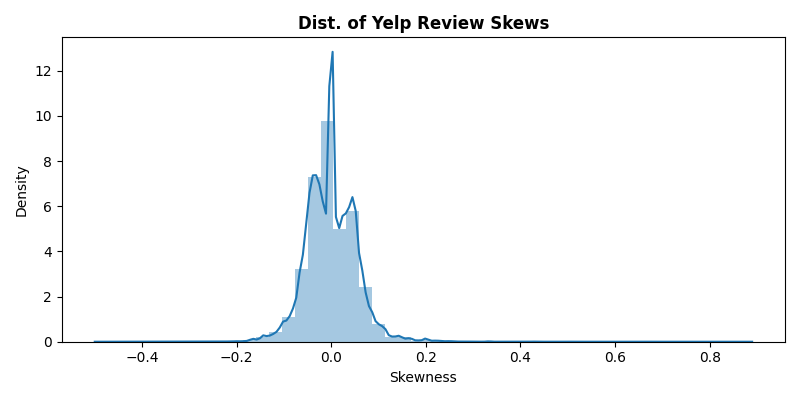

In [25]:
plt.figure(figsize=(8,4))
ax = sns.distplot(df_skew["skew"])
ax.set_xlabel('Skewness')

plt.yticks(size = 10)
plt.xticks(size = 10)
plt.title("Dist. of Yelp Review Skews", fontfamily = "Times New Roman", size = 12, weight='bold')

plt.tight_layout()

%matplot plt

So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph.

As seen from the graph above, the distribution is ever so slightly right skewed, yet overall it is normally distributed. It can also be inferred that the users who wrote those reviews were more satisfied than the normal.

# Part IV - Should the Elite be Trusted?

How accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating \
`s3://yelp-dataset-cis9760/yelp_academic_dataset_user.json`

Feel free to use any and all methodologies at your disposal. 
You must render one visualization in your analysis and interpret your findings.

In [26]:
user = spark.read.json('s3://yelp-dataset-cis9760/yelp_academic_dataset_user.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
print(f'Number of columns in Business table: {len(user.dtypes)}')
print(f'Number of rows in Business table: {user.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of columns in Business table: 22
Number of rows in Business table: 1,987,897

In [28]:
user.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

We will start our analysis by choosing only the elite users from our users table, and the display the results. \
But first, let's take a look at the elite column.

In [29]:
user.select("user_id", "elite").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|             user_id|               elite|
+--------------------+--------------------+
|qVc8ODYU5SZjKXVBg...|                2007|
|j14WgRoU_-2ZE1aw1...|2009,2010,2011,20...|
|2WnXYQFK0hXEoTxPt...|2009,2010,2011,20...|
|SZDeASXq7o05mMNLs...|      2009,2010,2011|
|hA5lMy-EnncsH4JoR...|                    |
+--------------------+--------------------+
only showing top 5 rows

As seen from above, elite users are those with year values entered on the elite column.
Those without any values on the elite column are considered non-elite users. \
We will filter our results by users whose elite column is **not blank.**

In [30]:
elite_users = user.select("user_id", "elite") \
                .filter(user["elite"] != '')
elite_users.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|             user_id|               elite|
+--------------------+--------------------+
|qVc8ODYU5SZjKXVBg...|                2007|
|j14WgRoU_-2ZE1aw1...|2009,2010,2011,20...|
|2WnXYQFK0hXEoTxPt...|2009,2010,2011,20...|
|SZDeASXq7o05mMNLs...|      2009,2010,2011|
|q_QQ5kBBwlCcbL1s4...|2006,2007,2008,20...|
+--------------------+--------------------+
only showing top 5 rows

Next, we will extract the reviews information from reviews table, and match it to the each elite users by inner joining them with the elite_users table.\
Here, we also give an alias to stars column as *review_stars* to tell it apart from the *stars* column from the business table.

In [31]:
reviews = review.select("business_id", "user_id", col("stars").alias("review_stars") )
elite_reviews = elite_users.join(reviews, reviews.user_id == elite_users.user_id).drop(reviews.user_id)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
elite_review_stars = elite_reviews.join(business, "business_id")\
            .select(elite_reviews.user_id, elite_reviews.business_id, elite_reviews.review_stars, business.stars)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
elite_review_stars.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+------------+-----+
|             user_id|         business_id|review_stars|stars|
+--------------------+--------------------+------------+-----+
|IeSz60ozr1yAVIH8C...|TV81bpCQ6p6o4Hau5...|         4.0|  4.5|
|xW2A0MciHB0pLB4RH...|W4ZEKkva9HpAdZG88...|         5.0|  4.0|
|SSafXe2aUO0cXgQhE...|E-4t5Hoon6aVFTWDP...|         5.0|  4.0|
|yiYUEExKfZEv_T8CF...|_pbx96FZ3eHJw-V_R...|         3.0|  2.5|
|A3EiqW7_k00gvaiQi...|8uF-bhJFgT4Tn6DTb...|         5.0|  4.5|
+--------------------+--------------------+------------+-----+
only showing top 5 rows

Now we will need to calculate the avg review stars for each business given by an elite user, and join it with elite_review_stars table.

In [34]:
##second we calculate the avg business star by elite review stars
elite_avg_stars = elite_review_stars.groupby("business_id").avg("review_stars")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
elite_avg_stars.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id| avg(review_stars)|
+--------------------+------------------+
|zJErbOQMKX-MwHs_u...|3.0697674418604652|
|HSzSGdcNaU7heQe0N...| 3.090909090909091|
|skW4boArIApRw9DXK...|               2.6|
|I0053JmJ5DEFUWSJ8...| 2.391304347826087|
|kPG6r0h73sPgXBei0...| 4.225806451612903|
+--------------------+------------------+
only showing top 5 rows

In [36]:
##and finally we join elite_avg_stars to our elite_review_stars table
elrevstr = elite_review_stars.join(elite_avg_stars, "business_id") \
            .select(elite_reviews.business_id, 
                   elite_reviews.review_stars, 
                   business.stars,
                   col("avg(review_stars)").alias("avg_elite_review_stars"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
elrevstr.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+-----+----------------------+
|         business_id|review_stars|stars|avg_elite_review_stars|
+--------------------+------------+-----+----------------------+
|--gJkxbsiSIwsQKbi...|         4.0|  5.0|                   4.0|
|-02xFuruu85XmDn2x...|         5.0|  4.5|     4.863636363636363|
|-02xFuruu85XmDn2x...|         5.0|  4.5|     4.863636363636363|
|-02xFuruu85XmDn2x...|         5.0|  4.5|     4.863636363636363|
|-02xFuruu85XmDn2x...|         5.0|  4.5|     4.863636363636363|
+--------------------+------------+-----+----------------------+
only showing top 5 rows

Finally, we have all the data we need to calculate the skew of difference between the actual avg business stars vs
the avg review stars given by the elite users.

After converting our RDD into pandas Dataframe, we will calculate the skew, the same way as we did in Part III:

```
(row['avg_elite_review_stars'] - row['stars']) / row['stars']
```

In [38]:
##we convert it to pandas df
elrevstr_df = elrevstr.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
##add a new column called skew to measure the dif between the actual business stars vs. the avg elite review stars
elrevstr_df["skew"] = (elrevstr_df['avg_elite_review_stars'] - elrevstr_df['stars']) / elrevstr_df['stars']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
print(elrevstr_df.head(5))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

              business_id  review_stars  ...  avg_elite_review_stars      skew
0  --gJkxbsiSIwsQKbiwm_Ng           4.0  ...                4.000000 -0.200000
1  -02xFuruu85XmDn2xiynJw           5.0  ...                4.863636  0.080808
2  -02xFuruu85XmDn2xiynJw           5.0  ...                4.863636  0.080808
3  -02xFuruu85XmDn2xiynJw           5.0  ...                4.863636  0.080808
4  -02xFuruu85XmDn2xiynJw           5.0  ...                4.863636  0.080808

[5 rows x 5 columns]

In [41]:
elrev_skewness = elrevstr_df["skew"].skew()
print(elrev_skewness)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

3.016210545517221

The skewness came out 3.0, therefore we expect our distribution to be right skewed.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

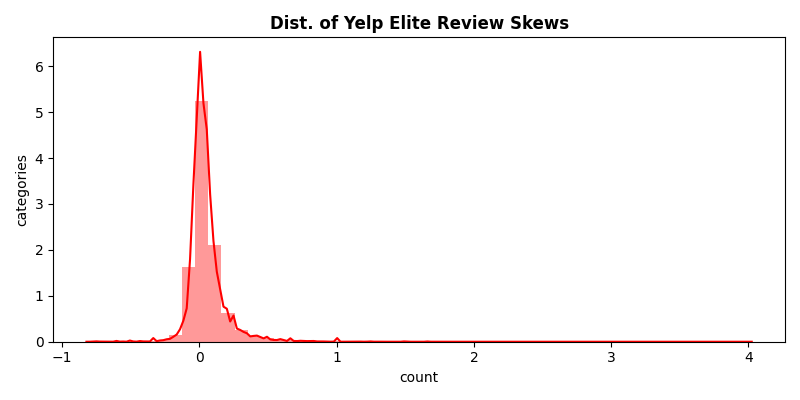

In [42]:
plt.figure(figsize=(8,4))
sns.distplot(elrevstr_df["skew"], color="red" )

plt.yticks(size = 10)
plt.xticks(size = 10)
plt.title("Dist. of Yelp Elite Review Skews", fontfamily = "Times New Roman", size = 12, weight='bold')
plt.xlabel("count", fontfamily = "Times New Roman", size = 10)
plt.ylabel("categories", fontfamily = "Times New Roman", size = 10)

plt.tight_layout()

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

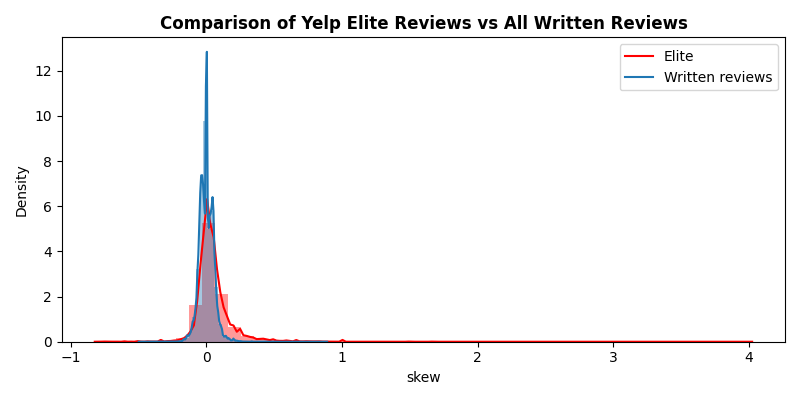

In [43]:
plt.figure(figsize=(8,4))
sns.distplot(elrevstr_df["skew"], color="red" )
sns.distplot(df_skew["skew"])
ax.set_xlabel('Skewness')

plt.yticks(size = 10)
plt.xticks(size = 10)
plt.title("Comparison of Yelp Elite Reviews vs All Written Reviews", fontfamily = "Times New Roman", size = 12, weight='bold')
plt.legend(["Elite", "Written reviews"])

plt.tight_layout()

%matplot plt

As seen from above graphs, there is quite a difference between the distribution of All Written Reviews and the Elite Reviews. Elite reviews have more outliers on both ends of the graph. And the distribution is right skewed. Therefore, I suggest that Elite Reviews should not be trusted as Elite Users tend to give higher review stars than the actual business ratings.

## Part V -What are the Most Common Unigrams and Bigrams in Hotels & Travel Reviews?

## Loading the Data

Since we have some text data included in our dataset, I wanted to analyze the most common unigrams (one-word-sequence), and bigrams (two-word_sequence) in Hotels & Travel Reviews. \

First, we extract the text and business_id columns from the review dataset. And filter the rows to make sure the text column is not empty.

In [44]:
review_text = review.select("business_id", "text")\
                .filter(review["text"] != '')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Second, we identify all businesses who falls in "Hotels & Travel Category", and then join them on business_id with review_text table we created previously.

In [45]:
hotels_travel = business_categories.select("business_id", "category")\
                .filter(business_categories["category"]=="Hotels & Travel")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [61]:
ht_reviews = review_text.join(hotels_travel, "business_id").select(review.text)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Before we start our text analysis, we convert our RDD table into pandas dataframe. Because we want to take advantage of python's nltk package for the analysis.

In [62]:
df = ht_reviews.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [63]:
print(df.head(5))
print(len(df))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                text
0  Loved this tour! I grabbed a groupon and the p...
1  We checked in around 2:30 pm.  Check-in was qu...
2  Comfortable bed, good breakfast, fast internet...
3  The TV shows are $4.99 and they have commercia...
4  The kayaking tour at the Santa Cruz Island was...
329658

## Pre-processing our Text

Text Preprocessing is an important aspect for natural langauge processing. In order to use any kind of text data for analysis, we first need to change it into a digestible format such as by removing nonrelevant characters, stopwords, urls, and then apply lemmatization and tokenization techniques to turn the text into group of words.

Below, we have defined a function *clean_text* to preprocess our text and assign it into a new column. I added comments for each regex expression as well.

Another thing is that we manually insert stopwords (commonly-used words) such as "a", "am", "is "into a list array so that we can skip those words for our analysis.

*NLTK package allready has a stopwords corpus, but for this project I chose to manually insert them into an array.*

In [64]:
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [65]:
def clean_text(text):
    
    # lowercase all letters
    text = text.lower()
    
    # remove emojis
    text = text.encode('ascii','ignore')
    text = text.decode()

    # replacing handlers with empty string
    text = re.sub('@[^\s]+',"",text)
    
    # remove punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    # replacing URLs with empty string
    text = re.sub(r"http\S+", "",text)

    # remove all the special characters
    text = ' '.join(re.findall(r'\w+', text))

    # replacing single characters with empty string
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # remove stopwords
    text = ' '.join([word for word in text.split() if not word in set(stopwords)])
    
    # words to singular forms
    stemmer = PorterStemmer()
    text = stemmer.stem(text)
    
    return text

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [66]:
df["prep_text"] = df["text"].apply(lambda x : clean_text(x))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
print(df.head(10))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                text                                          prep_text
0  Loved this tour! I grabbed a groupon and the p...  loved tour grabbed groupon price great perfect...
1  We checked in around 2:30 pm.  Check-in was qu...  checked around pm check quick easy complimenta...
2  Comfortable bed, good breakfast, fast internet...  comfortable bed good breakfast fast internet g...
3  The TV shows are $4.99 and they have commercia...  tv shows commercials cheesy way make money sig...
4  The kayaking tour at the Santa Cruz Island was...  kayaking tour santa cruz island great husband ...
5  I have been to a number of dog friendly hotels...  number dog friendly hotels city know expect us...
6  My parents and I took the Oak Alley and Laura ...  parents took oak alley laura plantation tour s...
7  Great customer service! We were a little out o...  great customer service little pick area accomm...
8  I had numerous things happen during my move an...  numerous t

After preprocessing is done, you can see how much it looks different from the original text above.

Next we introduce "regexptokenizer" to tokenize each sentence into a word tokens.
In order to run the tokenizer, we first insert the preprocessed text into a list, and apply regexptokenizer.

In [69]:
tokenizer = RegexpTokenizer("[\w']+")

text = list(df['prep_text'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [70]:
words = [tokenizer.tokenize(t) for t in text]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

After the tokenization is completed we append each tokenized word into a list and calculate the frequency distribution.

In [71]:
word = [w for word in words for w in word]
fdist = nltk.FreqDist(w for w in word)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [72]:
unigrams = [item[0] for item in fdist.most_common(20)]
frquni = [item[1] for item in fdist.most_common(20)]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [74]:
fdist=nltk.FreqDist((x,y) for (x,y) in nltk.bigrams(word))
most_common=fdist.most_common(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [75]:
top_words=[word for (word, freq) in most_common]
frqbi = [freq for (word, freq) in most_common]
bigrams = [' '.join(i) for i in top_words]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

And finally we graph the most common unigrams and bigrams as below.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

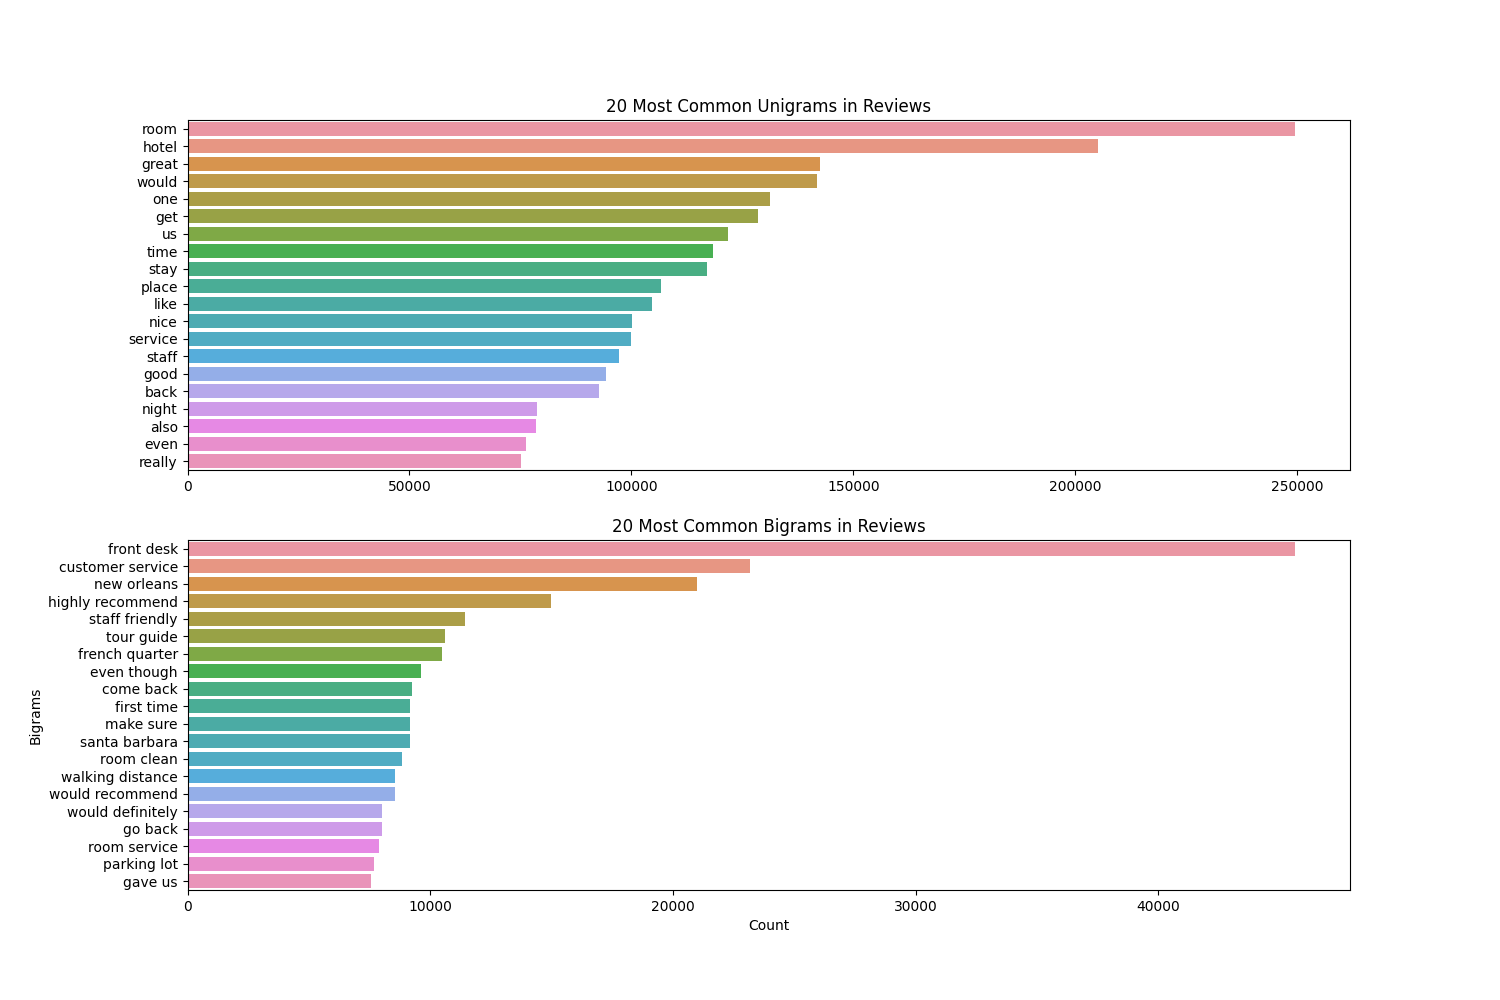

In [76]:
fig, axes = plt.subplots(2,1, figsize=(15,10))

sns.barplot(y=unigrams, x=frquni, ax=axes[0]).set(title='20 Most Common Unigrams in Reviews')
plt.xlabel("Count")
plt.ylabel("Unigrams")

sns.barplot(y=bigrams, x=frqbi, ax=axes[1]).set(title='20 Most Common Bigrams in Reviews')
plt.xlabel("Count")
plt.ylabel("Bigrams")

%matplot plt